#  Customer Churn Prediction – End-to-End Machine Learning Pipeline

This project builds a **production-ready machine learning pipeline** to predict customer churn using structured customer data.

###  Key Highlights
- Data cleaning & preprocessing
- Exploratory Data Analysis (EDA)
- Feature encoding & outlier handling
- Feature selection using Random Forest
- Model comparison using GridSearchCV
- Model & artifacts export for deployment (Streamlit / API)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

##  Dataset Loading

We load the **Customer Churn dataset** and perform an initial inspection to understand:
- Data types
- Missing values
- Overall structure of the dataset


In [4]:
df = pd.read_excel("/content/Customer_Churn_Dataset.xlsx")

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


##  Data Cleaning

### Handling Missing & Invalid Values
- Converted `TotalCharges` to numeric format
- Filled missing values with `0`
- Dropped irrelevant identifier column (`customerID`)

These steps ensure the dataset is **model-ready** and free from data type issues.


In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

In [7]:
df.drop("customerID",axis=1,inplace=True)

##  Exploratory Data Analysis (EDA)

### Numerical Features
- Distribution plots help understand skewness and spread
- Useful for detecting outliers and abnormal patterns

### Categorical Features
- Count plots visualize class balance
- Helps identify dominant categories and imbalance

EDA provides intuition before applying preprocessing and modeling.


In [8]:
df.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


In [9]:
df.shape

(7043, 22)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


<Axes: >

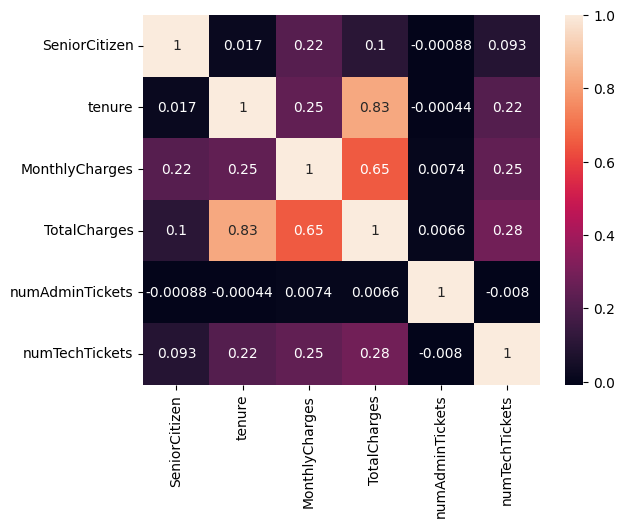

In [11]:
sns.heatmap(df.corr(numeric_only=True),annot=True)

In [12]:
numerical_col = df.select_dtypes(include=["int64","float64"]).columns
categorical_col = df.select_dtypes(include="object").columns

In [13]:
def plot_numurical(val, num, total):
    plt.subplot((total+1)//2, 2, num)
    sns.histplot(df[val], kde=True)
    plt.title(val)

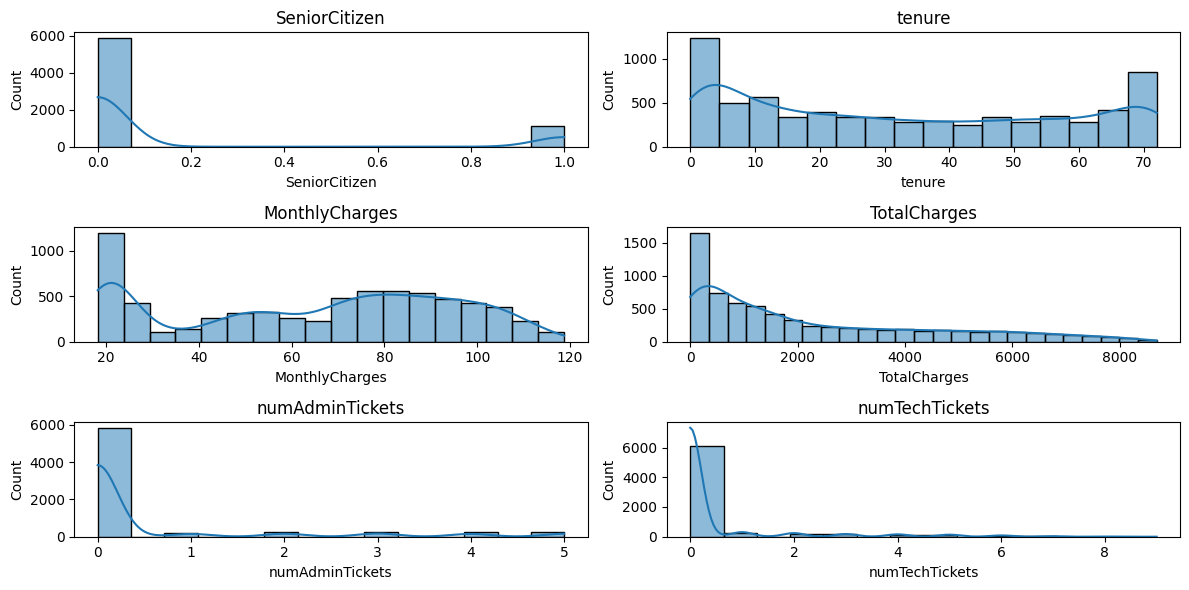

In [14]:
plt.figure(figsize=(12, 6))

for i, col in enumerate(numerical_col, 1):
    plot_numurical(col, i, len(numerical_col))

plt.tight_layout()
plt.show()

In [15]:
def plot_categorical(val, ax):
    sns.countplot(x=df[val], ax=ax)
    ax.set_title(val)
    ax.tick_params(axis='x', rotation=45)  # rotate x labels if long

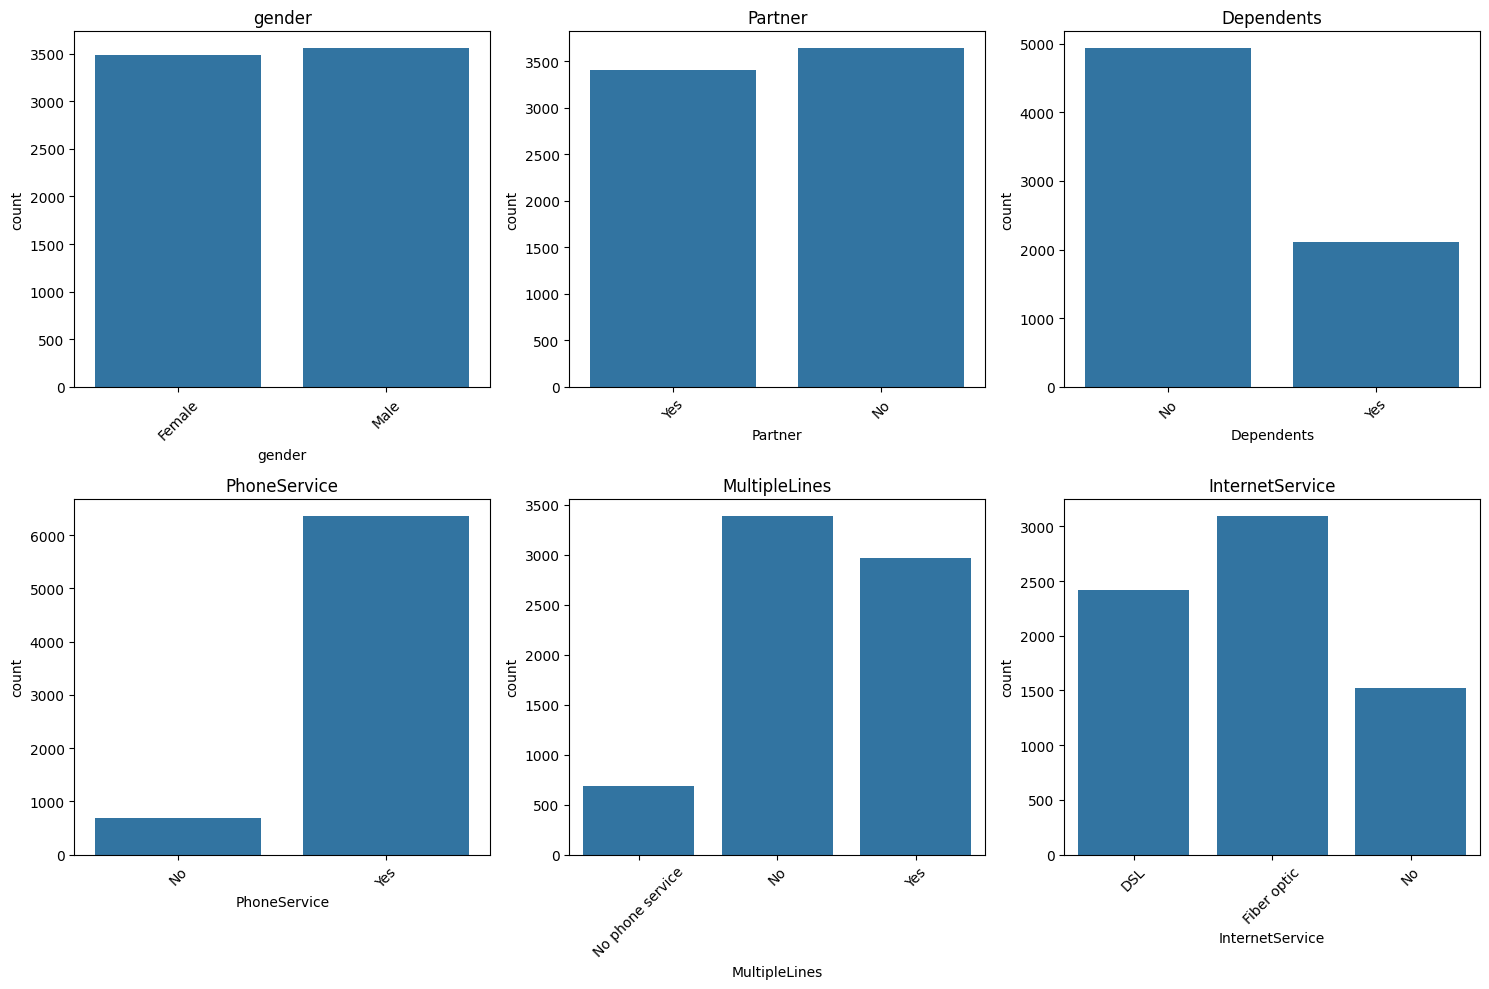

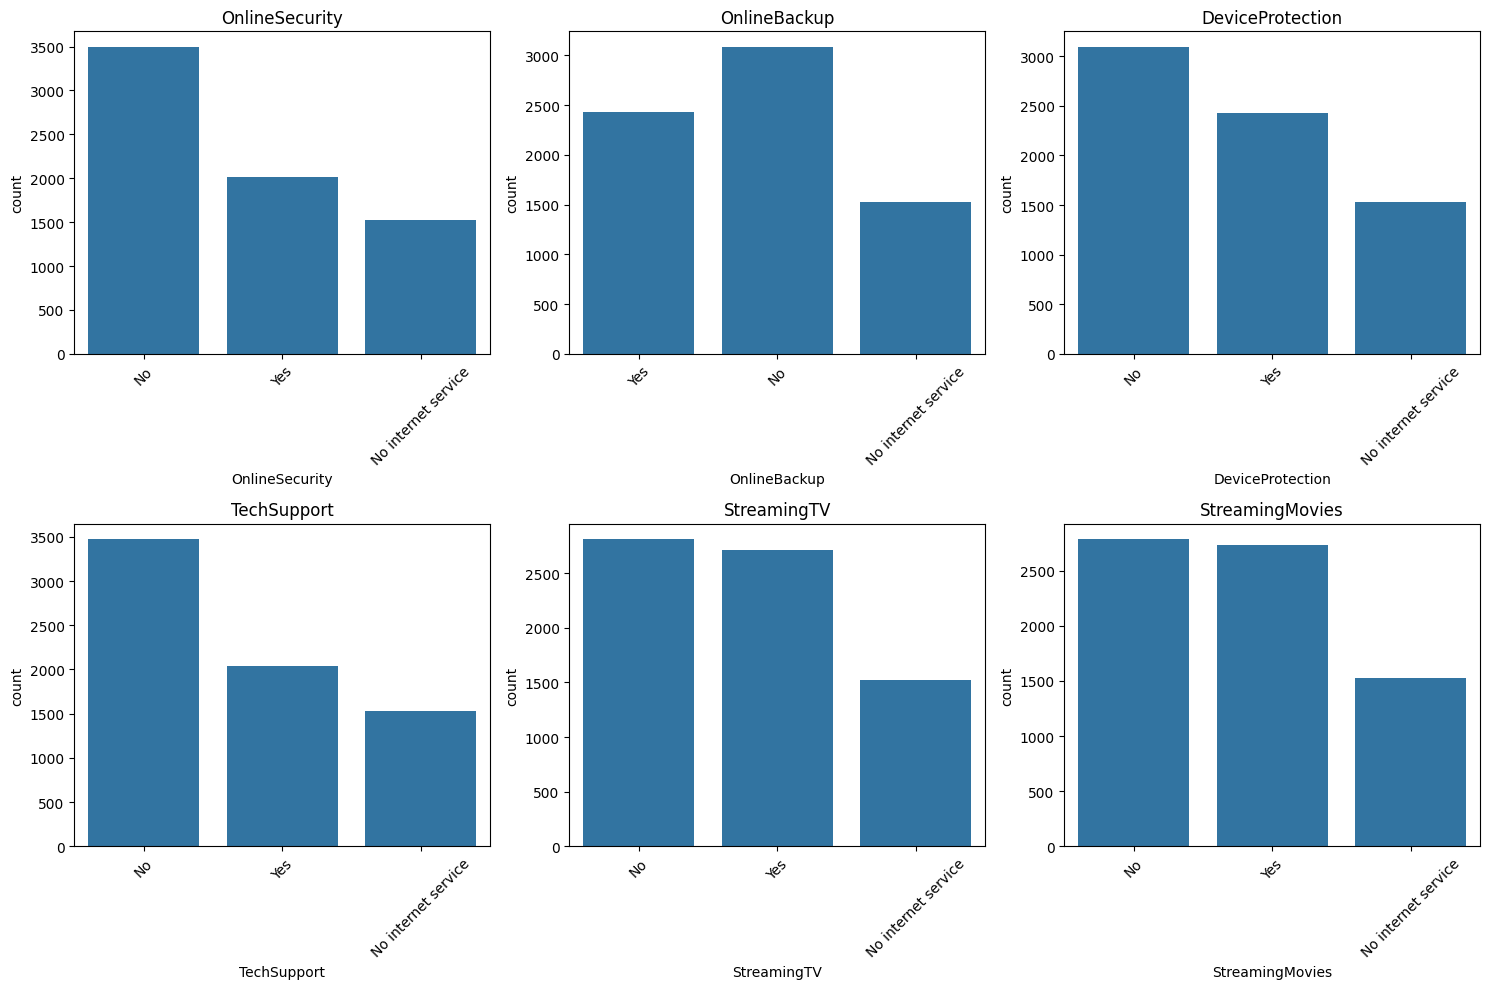

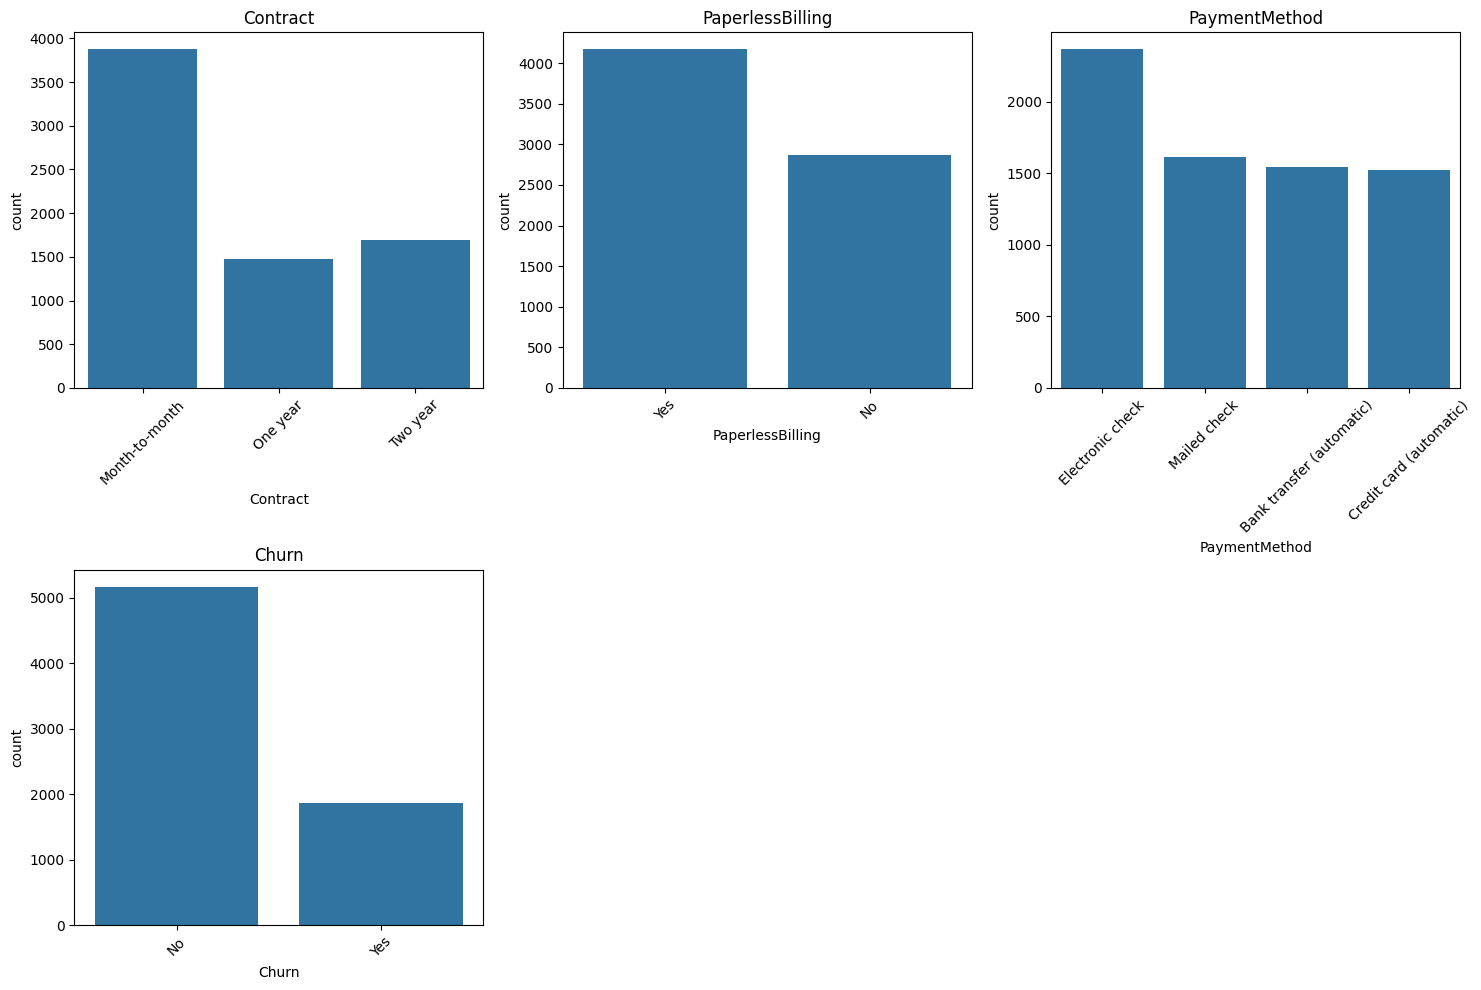

In [16]:
cols_per_fig = 3
rows_per_fig = 2
plots_per_fig = cols_per_fig * rows_per_fig

for i in range(0, len(categorical_col), plots_per_fig):
    fig, axes = plt.subplots(rows_per_fig, cols_per_fig, figsize=(15, 10))
    axes = axes.flatten()

    for j, col in enumerate(categorical_col[i:i+plots_per_fig]):
        plot_categorical(col, axes[j])

    for k in range(j+1, len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()


##  Feature Encoding Strategy

Different encoding techniques are applied based on feature cardinality:

- **Label Encoding**:
  - Applied to categorical columns with ≤ 4 unique values
  - Also applied to numerical categorical features (e.g., binary flags)

- **One-Hot Encoding**:
  - Applied to categorical columns with high cardinality

This hybrid strategy balances **model performance** and **feature interpretability**.


In [17]:
for_label_encode = [col for col in categorical_col if df[col].nunique() <= 4]
for_1hot_encode = [col for col in categorical_col if df[col].nunique() > 4]
num_cat_cols = [col for col in numerical_col if df[col].nunique() <= 5]

In [18]:
le = LabelEncoder()

In [19]:
for col in for_label_encode + num_cat_cols:
  df[col] = le.fit_transform(df[col])

In [20]:
df = pd.get_dummies(df,columns=for_1hot_encode)


In [21]:
df.dtypes

,0
gender,int64
SeniorCitizen,int64
Partner,int64
Dependents,int64
tenure,int64
PhoneService,int64
MultipleLines,int64
InternetService,int64
OnlineSecurity,int64
OnlineBackup,int64


##  Boolean Feature Handling

All boolean columns are converted to integer format (0 / 1) to ensure:
- Compatibility with machine learning models
- Consistent numerical representation


In [22]:
bool_cols = df.select_dtypes(include="bool").columns

In [23]:
df[bool_cols] = df[bool_cols].astype(int)

##  Outlier Treatment (IQR Method)

Outliers are capped using the **Interquartile Range (IQR)** method:
- Lower bound: Q1 − 1.5 × IQR
- Upper bound: Q3 + 1.5 × IQR

We use **clipping instead of removal** to:
- Preserve data size
- Avoid information loss


In [24]:
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df[col] = df[col].clip(lower, upper)

In [25]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'numAdminTickets', 'numTechTickets',
       'Churn'],
      dtype='object')

##  Feature Selection Using Random Forest

Random Forest feature importance is used to:
- Identify the most influential features
- Reduce dimensionality
- Improve model generalization

Only features with importance > **0.01** are retained.


In [26]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [27]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(min_samples_split=5, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [28]:
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)

,0
TotalCharges,0.177613
MonthlyCharges,0.172081
tenure,0.171238
Contract,0.101182
OnlineSecurity,0.054690
PaymentMethod,0.050403
TechSupport,0.043324
InternetService,0.032981
OnlineBackup,0.027108
PaperlessBilling,0.025091


In [29]:
top_features = feature_importance[feature_importance > 0.01].index
X_reduced = X[top_features]

print("Selected features:", len(top_features))

Selected features: 17


In [30]:
top_features

Index(['TotalCharges', 'MonthlyCharges', 'tenure', 'Contract',
       'OnlineSecurity', 'PaymentMethod', 'TechSupport', 'InternetService',
       'OnlineBackup', 'PaperlessBilling', 'MultipleLines', 'gender',
       'DeviceProtection', 'Partner', 'Dependents', 'StreamingMovies',
       'StreamingTV'],
      dtype='object')

In [31]:
X = df[top_features]
y = df["Churn"]

##  Train-Test Split

The dataset is split into training and testing sets:
- 80% training
- 20% testing
- Stratified on target variable (`Churn`)

This ensures **balanced class distribution** across splits.


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify = y
)

##  Model Training & Hyperparameter Tuning

Multiple classification models are trained and compared using **GridSearchCV**:

### Models Evaluated
- Logistic Regression
- K-Nearest Neighbors (KNN)
- Decision Tree
- Naive Bayes
- Random Forest
- Gradient Boosting

Each model is tuned using cross-validation to select the best hyperparameters.


In [33]:
models = {
    "Logistic": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.1, 1, 10]
        }
    },

    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3,5,7]
        }
    },

    # "SVM": {
    #     "model": SVC(),
    #     "params": {
    #         "C": [0.1, 1],
    #         "kernel": ["linear", "rbf"]
    #     }
    # },

    "DecisionTree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None, 5, 10]
        }
    },

    "NaiveBayes": {
        "model": GaussianNB(),
        "params": {}
    },

    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10]
        }
    },

    "Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1]
        }
    }
}


##  Best Model Selection

The best-performing model is selected based on **cross-validation accuracy**.

This ensures:
- Fair comparison
- Reduced overfitting risk
- Robust generalization


In [43]:
best_models = {}

for name, m in models.items():
    print(f"Training {name}...")

    gs = GridSearchCV(
        m["model"],
        m["params"],
        cv=5,
        scoring=["recall","precision"],
        refit="recall", # Explicitly set refit to 'recall'
        n_jobs=-1
    )

    gs.fit(X_train, y_train)

    best_models[name] = {
        "best_score": gs.best_score_,
        "best_params": gs.best_params_,
        "best_estimator": gs.best_estimator_ # Store the best fitted estimator
    }

Training Logistic...
Training KNN...
Training DecisionTree...
Training NaiveBayes...
Training RandomForest...
Training Boosting...


In [44]:
for model, info in best_models.items():
    print(model, "=>", info)

Logistic => {'best_score': np.float64(0.5431438127090301), 'best_params': {'C': 1}, 'best_estimator': LogisticRegression(C=1, max_iter=1000)}
KNN => {'best_score': np.float64(0.4642140468227424), 'best_params': {'n_neighbors': 3}, 'best_estimator': KNeighborsClassifier(n_neighbors=3)}
DecisionTree => {'best_score': np.float64(0.5270903010033445), 'best_params': {'max_depth': 10}, 'best_estimator': DecisionTreeClassifier(max_depth=10)}
NaiveBayes => {'best_score': np.float64(0.7391304347826086), 'best_params': {}, 'best_estimator': GaussianNB()}
RandomForest => {'best_score': np.float64(0.5110367892976588), 'best_params': {'max_depth': 10, 'n_estimators': 100}, 'best_estimator': RandomForestClassifier(max_depth=10)}
Boosting => {'best_score': np.float64(0.5130434782608695), 'best_params': {'learning_rate': 0.1, 'n_estimators': 100}, 'best_estimator': GradientBoostingClassifier()}


## Model Evaluation

Now, let's evaluate the performance of the `final_best_model` on the test set using various classification metrics.

In [45]:
best_model_name = max(best_models, key=lambda name: best_models[name]['best_score'])
final_best_model = best_models[best_model_name]['best_estimator']

y_pred = final_best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(best_model_name)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

NaiveBayes
Accuracy: 0.7466
Precision: 0.5160
Recall: 0.7326
F1-Score: 0.6055


### Confusion Matrix

A confusion matrix provides a detailed breakdown of correct and incorrect classifications.

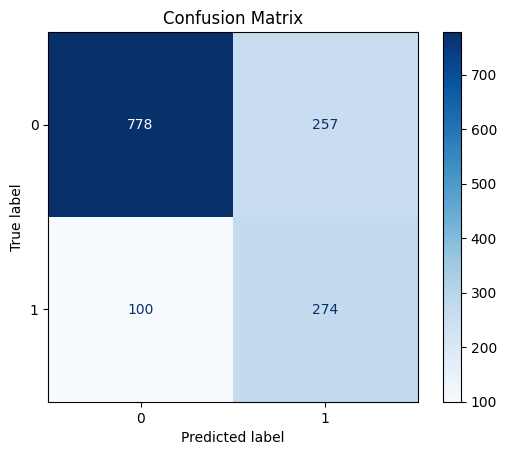

In [46]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


##  Model & Artifact Export

For deployment and reuse, the following artifacts are saved using `joblib`:

-  Trained ML model (`churn_model.pkl`)
-  Selected top features (`top_features.pkl`)
-  Label encoder (`label_encoder.pkl`)

These files enable seamless integration with **Streamlit dashboards** or **FastAPI services**.


In [47]:
top_features = list(top_features)
joblib.dump(top_features, "top_features.pkl")

['top_features.pkl']

In [48]:
best_model_name = max(best_models, key=lambda name: best_models[name]['best_score'])
final_best_model = best_models[best_model_name]['best_estimator']

joblib.dump(final_best_model, "churn_model.pkl")

['churn_model.pkl']

In [49]:
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']